In [8]:
# 处理温度信息
# -*- coding: utf-8 -*- 
from lxml import objectify
import pandas as pd
%matplotlib inline
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import copy
import matplotlib.dates as mdates
from dateutil import parser
import warnings
warnings.filterwarnings('ignore')
import random



import tensorflow as tf
import random
import os


TRAIN = True #设定训练还是inference

In [30]:
excel_path ='./data/temperature_.xlsx'
read_data = pd.read_excel(excel_path)

In [10]:
x_train = read_data
feature_number = x_train.shape[1]



def conv2d(x, W):
  return tf.nn.conv2d(input=x, filter=W, strides=[1, 1, 1, 1], padding='SAME')

def avg_pool_2x2(x):
  return tf.nn.avg_pool(x, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='SAME')

In [11]:
def discriminator(x_image, reuse=False):
    with tf.variable_scope('discriminator') as scope:
        if (reuse):
            tf.get_variable_scope().reuse_variables()
#         #First Conv and Pool Layers
#         W_conv1 = tf.get_variable('d_wconv1', [5, 5, 1, 8], initializer=tf.truncated_normal_initializer(stddev=0.02))
#         b_conv1 = tf.get_variable('d_bconv1', [8], initializer=tf.constant_initializer(0))
#         h_conv1 = tf.nn.relu(conv2d(x_image, W_conv1) + b_conv1)
#         h_pool1 = avg_pool_2x2(h_conv1)

#         #Second Conv and Pool Layers
#         W_conv2 = tf.get_variable('d_wconv2', [5, 5, 8, 16], initializer=tf.truncated_normal_initializer(stddev=0.02))
#         b_conv2 = tf.get_variable('d_bconv2', [16], initializer=tf.constant_initializer(0))
#         h_conv2 = tf.nn.relu(conv2d(h_pool1, W_conv2) + b_conv2)
#         h_pool2 = avg_pool_2x2(h_conv2)

        #First Fully Connected Layer
        W_fc1 = tf.get_variable('d_wfc1', [6, 32], initializer=tf.truncated_normal_initializer(stddev=0.02))
        b_fc1 = tf.get_variable('d_bfc1', [32], initializer=tf.constant_initializer(0))
        #h_pool2_flat = tf.reshape(h_pool2, [-1, 7*7*16])
        h_fc1 = tf.nn.relu(tf.matmul(x_image, W_fc1) + b_fc1)

        #Second Fully Connected Layer
        W_fc2 = tf.get_variable('d_wfc2', [32, 1], initializer=tf.truncated_normal_initializer(stddev=0.02))
        b_fc2 = tf.get_variable('d_bfc2', [1], initializer=tf.constant_initializer(0))

        #Final Layer
        y_conv=(tf.matmul(h_fc1, W_fc2) + b_fc2)
    return y_conv

In [12]:
def generator(z, batch_size, z_dim, reuse=False):
    with tf.variable_scope('generator') as scope:
        if (reuse):
            tf.get_variable_scope().reuse_variables()
            
            #First Fully Connected Layer
        g_W_fc1 = tf.get_variable('g_wfc1', [z_dim, 32], initializer=tf.truncated_normal_initializer(stddev=0.02))
        g_b_fc1 = tf.get_variable('g_bfc1', [32], initializer=tf.constant_initializer(0))
        #h_pool2_flat = tf.reshape(h_pool2, [-1, 7*7*16])
        g_h_fc1 = tf.nn.relu(tf.matmul(z,  g_W_fc1) +  g_b_fc1)

        #Second Fully Connected Layer
        g_W_fc2 = tf.get_variable('g_wfc2', [32, feature_number], initializer=tf.truncated_normal_initializer(stddev=0.02))
        g_b_fc2 = tf.get_variable('g_bfc2', [feature_number], initializer=tf.constant_initializer(0))

        #Final Layer
        g_y_conv=(tf.matmul(g_h_fc1,  g_W_fc2) +  g_b_fc2)
        
    return g_y_conv
            
            
#         g_dim = 64 #Number of filters of first layer of generator 
#         c_dim = 1 #Color dimension of output (MNIST is grayscale, so c_dim = 1 for us)
#         s = 28 #Output size of the image
#         s2, s4, s8, s16 = int(s/2), int(s/4), int(s/8), int(s/16) #We want to slowly upscale the image, so these values will help
#                                                                   #make that change gradual.

#         h0 = tf.reshape(z, [batch_size, s16+1, s16+1, 25])
#         h0 = tf.nn.relu(h0)
#         #Dimensions of h0 = batch_size x 2 x 2 x 25

#         #First DeConv Layer
#         output1_shape = [batch_size, s8, s8, g_dim*4]
#         W_conv1 = tf.get_variable('g_wconv1', [5, 5, output1_shape[-1], int(h0.get_shape()[-1])], 
#                                   initializer=tf.truncated_normal_initializer(stddev=0.1))
#         b_conv1 = tf.get_variable('g_bconv1', [output1_shape[-1]], initializer=tf.constant_initializer(.1))
#         H_conv1 = tf.nn.conv2d_transpose(h0, W_conv1, output_shape=output1_shape, strides=[1, 2, 2, 1], padding='SAME')
#         H_conv1 = tf.contrib.layers.batch_norm(inputs = H_conv1, center=True, scale=True, is_training=True, scope="g_bn1")
#         H_conv1 = tf.nn.relu(H_conv1)
#         #Dimensions of H_conv1 = batch_size x 3 x 3 x 256

#         #Second DeConv Layer
#         output2_shape = [batch_size, s4 - 1, s4 - 1, g_dim*2]
#         W_conv2 = tf.get_variable('g_wconv2', [5, 5, output2_shape[-1], int(H_conv1.get_shape()[-1])], 
#                                   initializer=tf.truncated_normal_initializer(stddev=0.1))
#         b_conv2 = tf.get_variable('g_bconv2', [output2_shape[-1]], initializer=tf.constant_initializer(.1))
#         H_conv2 = tf.nn.conv2d_transpose(H_conv1, W_conv2, output_shape=output2_shape, strides=[1, 2, 2, 1], padding='SAME')
#         H_conv2 = tf.contrib.layers.batch_norm(inputs = H_conv2, center=True, scale=True, is_training=True, scope="g_bn2")
#         H_conv2 = tf.nn.relu(H_conv2)
#         #Dimensions of H_conv2 = batch_size x 6 x 6 x 128

#         #Third DeConv Layer
#         output3_shape = [batch_size, s2 - 2, s2 - 2, g_dim*1]
#         W_conv3 = tf.get_variable('g_wconv3', [5, 5, output3_shape[-1], int(H_conv2.get_shape()[-1])], 
#                                   initializer=tf.truncated_normal_initializer(stddev=0.1))
#         b_conv3 = tf.get_variable('g_bconv3', [output3_shape[-1]], initializer=tf.constant_initializer(.1))
#         H_conv3 = tf.nn.conv2d_transpose(H_conv2, W_conv3, output_shape=output3_shape, strides=[1, 2, 2, 1], padding='SAME')
#         H_conv3 = tf.contrib.layers.batch_norm(inputs = H_conv3, center=True, scale=True, is_training=True, scope="g_bn3")
#         H_conv3 = tf.nn.relu(H_conv3)
#         #Dimensions of H_conv3 = batch_size x 12 x 12 x 64

#         #Fourth DeConv Layer
#         output4_shape = [batch_size, s, s, c_dim]
#         W_conv4 = tf.get_variable('g_wconv4', [5, 5, output4_shape[-1], int(H_conv3.get_shape()[-1])], 
#                                   initializer=tf.truncated_normal_initializer(stddev=0.1))
#         b_conv4 = tf.get_variable('g_bconv4', [output4_shape[-1]], initializer=tf.constant_initializer(.1))
#         H_conv4 = tf.nn.conv2d_transpose(H_conv3, W_conv4, output_shape=output4_shape, strides=[1, 2, 2, 1], padding='VALID')
#         H_conv4 = tf.nn.tanh(H_conv4)
#         #Dimensions of H_conv4 = batch_size x 28 x 28 x 1


In [13]:
#tf.reset_default_graph() #Since we changed our batch size (from 1 to 16), we need to reset our Tensorflow graph
#sess = tf.Session()
#sess.run(tf.global_variables_initializer())

z_dimensions = 10
in_dimensions = 6
#z_test_placeholder = tf.placeholder(tf.float32, [None, z_dimensions])
#他是这边有一个维度随机生成, 根据这个随机出来一个结果

In [14]:
#sample_image = generator(z_test_placeholder, 1, z_dimensions, reuse=True)
#test_z = np.random.normal(-1, 1, [1,z_dimensions])
#按照这个随机生成

In [15]:

#sess.run(tf.global_variables_initializer())
#temp = (sess.run(sample_image, feed_dict={z_test_placeholder: test_z}))

In [16]:
batch_size = 16
tf.reset_default_graph() #Since we changed our batch size (from 1 to 16), we need to reset our Tensorflow graph

sess = tf.Session()



x_placeholder = tf.placeholder("float", shape = [None,feature_number]) #Placeholder for input images to the discriminator
z_placeholder = tf.placeholder(tf.float32, [None, z_dimensions]) #Placeholder for input noise vectors to the generator
r_placeholder = tf.placeholder(tf.float32,[None, feature_number])

In [17]:
Dx = discriminator(x_placeholder) #Dx will hold discriminator outputs (unnormalized) for the real MNIST images
Gz = generator(z_placeholder, batch_size, z_dimensions) #Gz holds the generated images
Dg = discriminator(Gz, reuse=True) #Dg will hold discriminator outputs (unnormalized) for generated images
Dr = discriminator(r_placeholder,reuse=True)

In [18]:



g_loss = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=Dg, labels=tf.ones_like(Dg)))

real_probability = tf.nn.softmax(Dr)
#真实概率 

d_loss_real = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=Dx, labels=tf.ones_like(Dx)))
d_loss_fake = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=Dg, labels=tf.zeros_like(Dg)))
d_loss_random = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=Dr, labels=tf.zeros_like(Dr)))

d_loss = d_loss_real + d_loss_fake + d_loss_random

tvars = tf.trainable_variables()
d_vars = [var for var in tvars if 'd_' in var.name]
g_vars = [var for var in tvars if 'g_' in var.name]

with tf.variable_scope(tf.get_variable_scope(), reuse=False):
    trainerD = tf.train.AdamOptimizer().minimize(d_loss, var_list=d_vars)
    trainerG = tf.train.AdamOptimizer().minimize(g_loss, var_list=g_vars)
    
    





In [19]:
folder = os.path.exists('checkpoint')

if not folder:
    os.mkdir('checkpoint')

In [20]:
from IPython.display import clear_output, Image, display, HTML


def strip_consts(graph_def, max_const_size=32):
    """Strip large constant values from graph_def."""
    strip_def = tf.GraphDef()
    for n0 in graph_def.node:
        n = strip_def.node.add() 
        n.MergeFrom(n0)
        if n.op == 'Const':
            tensor = n.attr['value'].tensor
            size = len(tensor.tensor_content)
            if size > max_const_size:
                tensor.tensor_content = bytes("<stripped %d bytes>"%size, 'utf-8')
    return strip_def

def show_graph(graph_def, max_const_size=32):
    """Visualize TensorFlow graph."""
    if hasattr(graph_def, 'as_graph_def'):
        graph_def = graph_def.as_graph_def()
    strip_def = strip_consts(graph_def, max_const_size=max_const_size)
    code = """
        <script>
          function load() {{
            document.getElementById("{id}").pbtxt = {data};
          }}
        </script>
        <link rel="import" href="https://tensorboard.appspot.com/tf-graph-basic.build.html" onload=load()>
        <div style="height:600px">
          <tf-graph-basic id="{id}"></tf-graph-basic>
        </div>
    """.format(data=repr(str(strip_def)), id='graph'+str(np.random.rand()))

    iframe = """
        <iframe seamless style="width:1200px;height:620px;border:0" srcdoc="{}"></iframe>
    """.format(code.replace('"', '&quot;'))
    display(HTML(iframe))

In [28]:
iterations = 20000


random_input = np.random.standard_normal(size=[batch_size,feature_number])
random_input_train = np.random.standard_normal(size=[batch_size,feature_number])

sess.run(tf.global_variables_initializer())
#写一个记录
show_graph(tf.Session().graph) #显示图片

saver = tf.train.Saver()


ckpt = tf.train.get_checkpoint_state(os.path.dirname('./checkpoint-fashion/checkpoint'))

if ckpt and ckpt.model_checkpoint_path:
    saver.restore(sess, ckpt.model_checkpoint_path)

INFO:tensorflow:Restoring parameters from ./checkpoint-fashion/checkpoint-19000


In [23]:

if TRAIN:


    store = np.empty([int(iterations/100),2], dtype = float)

    for i in range(iterations):

        z_batch = np.random.normal(-1, 1, size=[batch_size, z_dimensions])
        real_image_batch = np.array(x_train)[i%100:i%100+1,:feature_number]
        _,dLoss = sess.run([trainerD, d_loss],feed_dict={z_placeholder:z_batch,x_placeholder:real_image_batch, r_placeholder:random_input_train}) #Update the discriminator
        _,gLoss = sess.run([trainerG, g_loss],feed_dict={z_placeholder:z_batch}) #Update the generator     
        if i%1000 == 0:
            print("discriminator: ", dLoss, "generator", gLoss)
            store[int(i/100-1),0] = dLoss #存储到两个loss当中
            store[int(i/100-1),1] = gLoss

        if i%1000 == 0:

            #print("real_probability:", sess.run(real_probability,feed_dict={r_placeholder:random_input_train}))
            #是没有错的, 但是肯定是1 因为没有错误的
            saver.save(sess, './checkpoint-fashion/checkpoint', i)
            
else:


    store = np.empty([int(iterations/100),2], dtype = float)

    for i in range(iterations):

        z_batch = np.random.normal(-1, 1, size=[batch_size, z_dimensions])
        real_image_batch = np.array(x_train)[i%100:i%100+1,:feature_number]
        dLoss = sess.run(d_loss,feed_dict={z_placeholder:z_batch,x_placeholder:real_image_batch, r_placeholder:random_input_train}) #Update the discriminator
        gLoss = sess.run(g_loss,feed_dict={z_placeholder:z_batch}) #Update the generator     
        if i%1000 == 0:
            print("discriminator: ", dLoss, "generator", gLoss)
            store[int(i/100-1),0] = dLoss #存储到两个loss当中
            store[int(i/100-1),1] = gLoss

        if i%1000 == 0:

            print("real_probability:", sess.run(real_probability,feed_dict={r_placeholder:np.random.standard_normal(size=[batch_size,feature_number])}))
            #是没有错的, 但是肯定是1 因为没有错误的

    
    
    

discriminator:  1.487229 generator 0.8599868
discriminator:  2.2809718 generator 0.3695252
discriminator:  1.5820982 generator 1.0571108
discriminator:  1.5702999 generator 0.95153606
discriminator:  0.89942396 generator 0.8387175
discriminator:  2.056249 generator 1.0817354
discriminator:  2.249499 generator 0.29555306
discriminator:  1.4204361 generator 0.9505301
discriminator:  0.97486657 generator 1.034741
discriminator:  2.1583078 generator 0.5987959
discriminator:  0.9012499 generator 1.1967559
discriminator:  1.423936 generator 0.91869205
discriminator:  1.6034501 generator 0.7595043
discriminator:  1.3047712 generator 0.8929147
discriminator:  0.92870945 generator 1.68311
discriminator:  1.2413859 generator 0.9098284
discriminator:  1.5924058 generator 0.6492413
discriminator:  1.2149594 generator 0.880244
discriminator:  1.9162351 generator 0.46635938
discriminator:  1.2148696 generator 0.9272186


In [29]:


name = ['02#主控室温度','03#主控室温度','04#高压室温度','05#高压室温度','06#27.5KV室温度','07#10KV室温度']
val = np.zeros((1,len(name)))
print(val)
for type in range(len(name)):
    val[0,type] = input(prompt=name[type])
print(val)

print("real_probability:", sess.run(real_probability,feed_dict={r_placeholder:val})) #Update the generator 


[[0. 0. 0. 0. 0. 0.]]
02#主控室温度5
03#主控室温度6
04#高压室温度4
05#高压室温度8
06#27.5KV室温度9
07#10KV室温度10
[[ 5.  6.  4.  8.  9. 10.]]
real_probability: [[1.]]


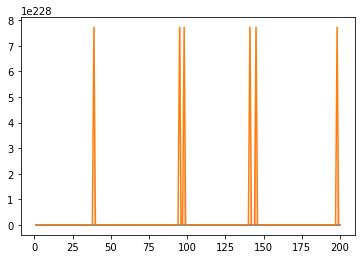

In [16]:
from matplotlib.pyplot import *
x = np.linspace(1,200,200)

y1 = store[:,0]
y2 = store[:,1]
fill_between(x,y1,y2,where=(y1>=y2),color = 'green', alpha=0.25)
fill_between(x,y1,y2,where=(y1<y2),color = 'red', alpha=0.25)
plot(x,y1)
plot(x,y2)
show()

In [17]:
writer = pd.ExcelWriter('./data/Loss_.xlsx')
count_array = pd.DataFrame(store)
count_array.to_excel(writer, 'page_1', header=False, index=False)
writer.save()